<a href="https://colab.research.google.com/github/husenlan/testhh/blob/master/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

In [3]:
!pip install python==3.8
!pip install transformers==4.38.1
!pip install safetensors==0.4.5
!pip install torch==1.12.1
!pip install diffusers==0.25.0
!pip install huggingface_hub==0.20.2
!pip install accelerate==0.23.0

ERROR: Could not find a version that satisfies the requirement python==3.8.1 (from versions: none)
ERROR: No matching distribution found for python==3.8.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.8 MB/s eta 0:00:00
  Using cached huggingface_hub-0.29.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 75.8 MB/s eta 0:00:00
Using cached huggingface_hub-0.29.1-py3-none-any.whl (468 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.2.6
    Uninstalling safetensors-0.2.6:
      Successfu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.5.3
    Uninstalling safetensors-0.5.3:
      Successfully uninstalled safetensors-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires accelerate>=0.21.0, but you have accelerate 0.18.0 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement torch==1.12.1 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.12.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.5 MB/s eta 0:00:00
  Attemp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.18.0
    Uninstalling accelerate-0.18.0:
      Successfully uninstalled accelerate-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires huggingface-hub>=0.25.0, but you have huggingface-hub 0.20.2 which is incompatible.


To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
!pip uninstall xformers

Found existing installation: xformers 0.0.24
Uninstalling xformers-0.0.24:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/xformers-0.0.24.dist-info/*
    /usr/local/lib/python3.11/dist-packages/xformers/*
Proceed (Y/n)? 
  Successfully uninstalled xformers-0.0.24


In [4]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL

from diffusers import StableDiffusionInpaintPipeline

In [5]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [13]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


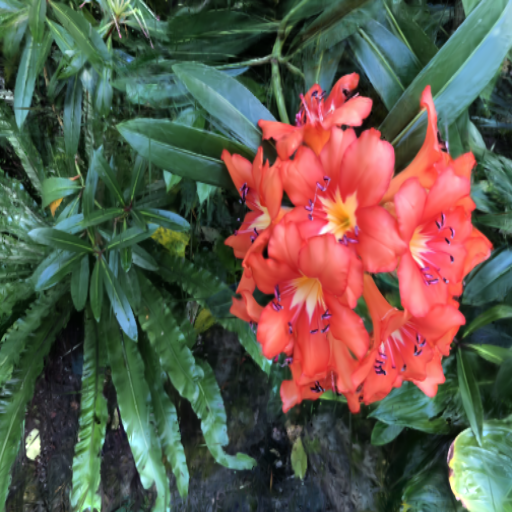

In [8]:

image_path = '/content/drive/MyDrive/renderedIMG_2963.png'
image = PIL.Image.open(image_path)
image

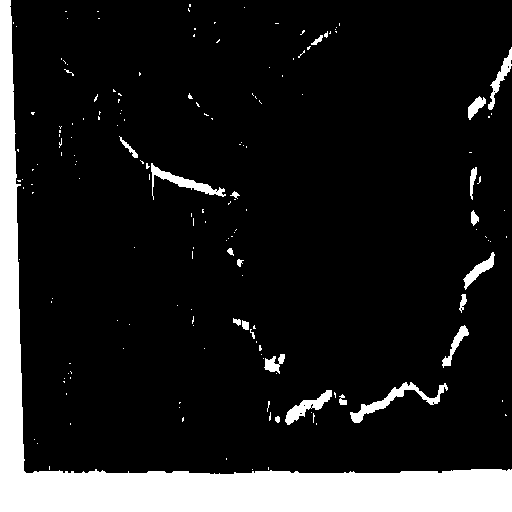

In [9]:

image_path = '/content/drive/MyDrive/maskIMG_2963.png'
mask_image = PIL.Image.open(image_path)
mask_image

In [10]:
prompt = "a photography of a flower in the garden"

guidance_scale=7.5
num_samples = 1
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

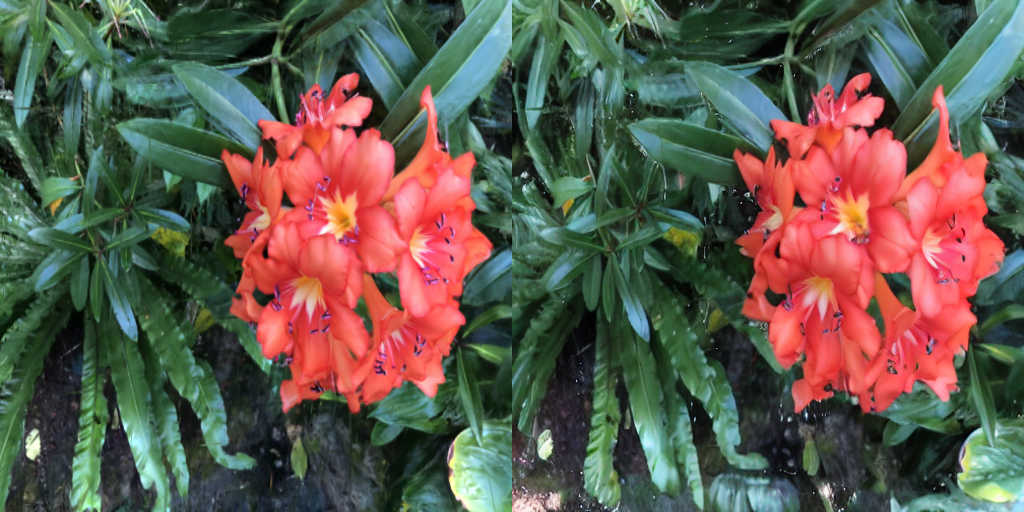

In [14]:
image_grid(images, 1, num_samples + 1)

### Gradio Demo

In [ ]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [ ]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e52f060882d60b09.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7eff58b4ef90>,
 'http://127.0.0.1:7860/',
 'https://e52f060882d60b09.gradio.app')